# Bayesian A/B testing

## Explore vs Exploit dilemma

- **Example**: you "know" a drug is working, but Frequentist statistics say you shouldn't stop until the originally determined sample size is reached. That is because we are increasing the chance of finding false positives (nature of frequentist statistics)
     - as we saw before, the p-value can go below and over the threshold over time (unstable)

### Multi-Armed Bandit problem

- You're at a casino playing slots (pulling the "arm)
- Machines have different payout probabilities
     - 1 pays 30% of the time, 1 pays 20% of the time and 1 pays 10% of the time
- in frequentist statistics you would do an A/B test for a specific # N of trials and then calculate the p-value. 
    - But this has a cost associated with it!

What would you do in real life?
- you would probably adapt based on the data you collect at every "arm pull"
    - 3 plays probably not enough to attain significance, but you still feel compelled to believe that the first arm is better. 
    
**Related: Reinforcement Learning**
- teach a machine to play a game
    - faces the same problem
- it models rewards it gets based on the previous action
- but the process could be stochastic (~random!), so the reward estimates will be approxmate
- **Early on in the learning**: few actions have been taken, so we're unsure about most rewards
    - We can't "choose the action that leads to best reward", because our current, early knowledge about the reward is minimal
    - Only after collecting a lot of data will the estimate be accurate
    
    
This is the **Explpore/Exploit dilemma**

- if I get 3/3 from bandit 1, 0.3 from bandit 2, should I:
    - exploit bandit 1 more? or
    - explore at random to gather more data?
- we'll look at several solutions, not all Bayesian (but all adaptive)


### Epsilon-Greedy algorithm

- if you have an experiment for 2 ads, the idea is that you will adapt which advertisement you show more often based on which one is performing better
- You can **still** do frequentist A/B test after collecting the data, since the contingency table for chi-square test doesn't require both sampels ot be of the same size
- The thing that changes here is the **machine that serves the ads**
    - it will adapt to the performance of each ad

**How it works**

- Choose a small number `epsilon` between 0 and 1: that is the probability of exploration
- Create a while loop that generates random number `r`
    - if `r < epsilon`, then explore
    - if `r > epsilon`, then exploit
    
**Problems**
- it will keep doing the same thing forever
- even if A is statistically significantly bettwen than B, it will still sometimes show B

### Another algorithm: UCB1

#### Confidence intervals
- From previous examples, we define the upper and lower limit to represent where we belive the true Conversion Rate (CTR) is
- we'll now look at a similar idea, but using a "tighter" bound, **Chernoff-Hoeffding bound**

![chbound](img/ch_bound.png)

For each arm j, we "choose" the epsilon: 

![epsilon](img/epsilon_ucb.png)

where
- N = total games played so far
- Nj = total times played arm j (so far)


And which arm to play is determined by the equation:

![argmax_epsilon](img/epsilon_argmax.png)


- So we choose the choose the bandit with the highest upper bound (argmax...)
- we play that arm
- we update _mu_j
- we increment N and Nj

#### How is this different to Epsilon-Greedy?

- First term: Estimate of the conversion rate (_mu_) -> if an arm gives a higher estimate, exploit it more
- Second term: depends on N and Nj
    - If N is high (we've played many times), but Nj is low (this arm has been played few times), it means we're not very confident about CTRj, and we explore this more
- Finally, as N -> infinity, ln(N)/N approaches 0, so we will just be only using for the true highest conversion rate in the limit (without having to "try out B once in a while" like in the Epsilon-greedy case)

## Bayesian Paradigm

**Frequentist**
- we measure things like mean and CTR with point estimates
    - e.g. sum(X)/N
- to measure how accurate these point estimates are , we use confidence intervals and the Central Limit Theorem
- as well as teh Maximum likelihood solution

theta_hat = _argmax__theta*P(X|theta)

**Bayesian**
- treat theta as a random variable too, so it has its own distribution

![bayesian_prob](img/bayesian_estimate_prob.png)

- Z = normalizing constant
- P(X|theta) = likelihood (how likely is this data given current theta?)
- P(theta) = prior (old belief about theta)
- P(theta|X) = posterior (new belief about theta after seeing the data)


**how does it actually work?**
- these are all probability distributions!
- P(X) is the integral over P(X|theta)P(theta)dtheta
    - generally speaking, this is either hard or impossible to solve
    - One solution is to use sampling methods like Markov Chains Monte Carlo
    
If we **don't** want to use something like MCMC, we can use another, more elegant solution, called **Conjugate Priors**

### Conjugate Priors
- they give an elegant solution for P(theta|X)
- If we choose specific distributions fo P(X|theta) and P(theta), then we sort of know ("make") P(theta|X) the same type of distribution as P(theta)
- "for specific likelihood distributions and for specific prior distributions, the posterior distribution will be the same as the prior distribution"

**Example**
1. We know that the likelihood for click-through rate is Bernoulli: 

![bernoulli_likelihood](img/bernoulli_likelihood.png)

2. We also know that theta here must be between 0 and 1, because it's the probability of a click. 
    - This can be modelled as the Beta distribution 
    
![beta-dist](img/beta_dist.png)

How do we solve for this?

![conj_prior](img/conjugate_prior_ctr.png)

As alpha and beta get bigger, the variance gets smaller so we are more confident.

How do we choose the prior alpha and beta?
- We can choose any, such as alpha = 1 and beta = 1 (uniform)

#### Choosing conjugate priors
How do we know which prior pairs are conjugate?
[Wikipedia article](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions)

### Bayesian A/B testing in practice

1. How can we use the conjugate priors to solve the explore-exploit dilemma?
2. How can we do it better than the epsilon-greedy and UCB1 algorithms?

#### Click-through rate example
**Sampling**
`scipy` allows us to sample from any distribution we want
- We'll sample from the beta distribution

##### Scenario 1: we've already explored a lot

![scenario1](img/scenario1.png)

- we have sharp (low variance), high confidence estimates of our click through rates
- if we sample from these 2 beta dist, we expect with high probability that the one with the higher CTR will give us a higher random number
    - i.e. choose the bandit that gives us the largest random number from these two beta distributions. 
    - it is still possible for the worse bandit to give us a higher random number
    
##### Scenario 2: one bandit has been exploited a lot

![scenario2](img/scenario2.png)

- one bandit we're very sure of, but the other hasn't been explored enough to give us a narrower variance
- so the bandit with a larger variance is more likely to give us a larger number in this scenario 
    - i.e. it's the distributions themselves that tell us how much to explore or exploit
    - we decide to **explore more the green one**
- in the case above, more of the distribution of the fat curve falls below the "best case" (peak of the blue one)
    - we will **exploit more the blue one**


> This gives us a balance of exploit-explore. The method is called **"Thompson Sampling"** and it's used in reinforcement learning. 

### Example

In [17]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
NUM_TRIALS = 2000
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]

In [20]:
# Define a class called Bandit that will work as a slot machine
class Bandit(object):
    def __init__(self, p):
        self.p = p
        self.a = 1  #both priors will be 1, so uniform dist
        self.b = 1
    
    def pull(self):
        return np.random.random() < self.p
    
    def sample(self):
        return np.random.beta(self.a, self.b)
    
    def update(self, x):
        self.a += x
        self.b += 1 - x
        
def plot(bandits, trial):
    """
    will plot the PDF of every bandit so we can compare them on the same chart
    """
    x = np.linspace(0,1,200)
    for b in bandits:
        y = beta.pdf(x, b.a, b.b)
        plt.plot(x, y, label = "real p: %.4f" % b.p)
    plt.title("Bandit distributions after {} trials".format(trial))
    plt.legend()
    plt.show()

def experiment():
    bandits = [Bandit(p) for p in BANDIT_PROBABILITIES]
    # points we want to show on a plot
    sample_points = [5,10, 20, 50, 100, 200, 500, 1000, 1500, 1999]
    for i in range(NUM_TRIALS):
        bestb = None
        maxsample = -1
        allsamples = []
        for b in bandits:
            sample = b.sample() # sample a number from the beta
            allsamples.append("%.4f" % sample)
            if sample > maxsample:
                maxsample = sample
                bestb = b # the best bandit so far becomes the global one
        if i in sample_points: 
            print("current samples: {}".format(allsamples))
            plot(bandits, i)
        x = bestb.pull()
        bestb.update(x)

current samples: ['0.0775', '0.0225', '0.9301']


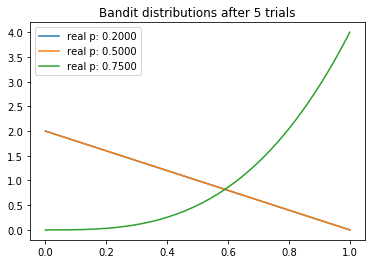

current samples: ['0.3201', '0.1407', '0.7735']


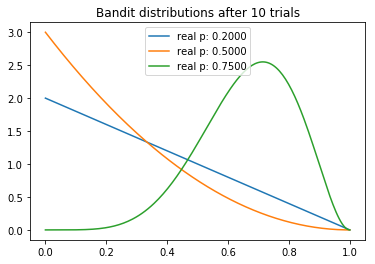

current samples: ['0.0809', '0.4761', '0.7966']


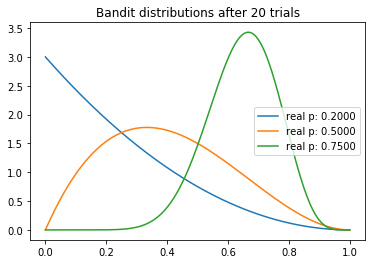

current samples: ['0.2039', '0.4975', '0.6265']


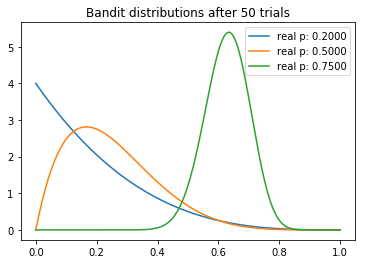

current samples: ['0.0888', '0.3352', '0.7600']


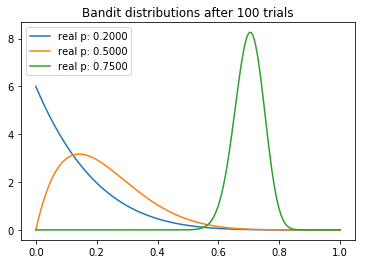

current samples: ['0.1505', '0.2530', '0.7076']


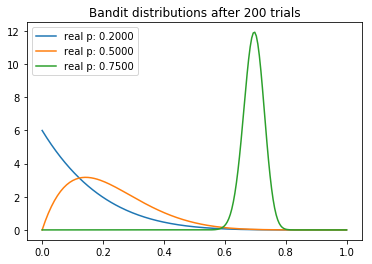

current samples: ['0.2534', '0.2651', '0.7505']


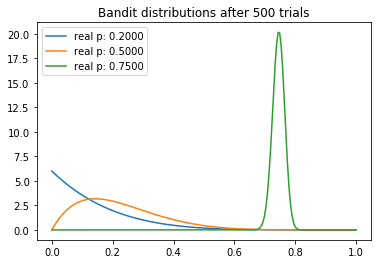

current samples: ['0.3221', '0.2426', '0.7638']


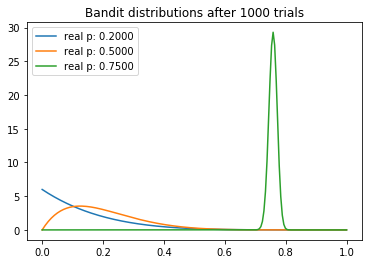

current samples: ['0.1650', '0.2036', '0.7378']


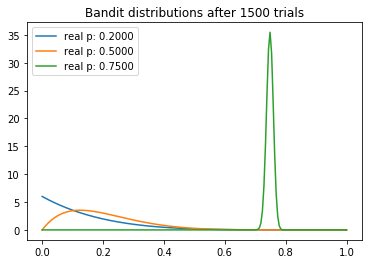

current samples: ['0.1160', '0.3742', '0.7537']


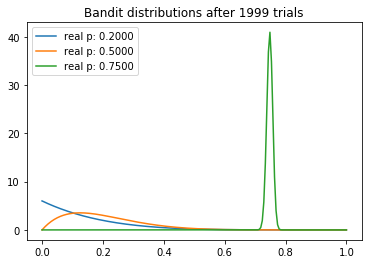

In [21]:
experiment()

We see that the one with the highest probability will become more certain while the others will remain with large variances (because we don't explore them much) and the algorithm is epsilon-greedy

### Finding a threshold without P values

At some point we want to stop the experiment, once we're comfortable enough that one version is better than the other. But when?

`P(mu_1 > mu_2)`

- _mu_ = click through rate
- both `mu_1` and `mu_2` are Beta-distributed

> *p-value*: the probability of obtaining a result equal to or "more extreme" than what is actually observed, when the null hypothesis is true

The p-values from frequentist statistics are not easily interpretable. 

**Deriving the p-value in Bayesian stats**

- `P(mu_1 > mu_2)` = `P(mu_1 - mu_2 > 0)` = `P(X > 0)` = area under the PDF from X to infinity
- PDF(X) = Beta1(X) * Beta2(-X) (convolution operator)

if we don't know the distribution of X!

So another route:
- Joint PDF = `p(mu_1, mu_2)` = `p(mu_1)*p(mu_2)`
- `P(mu_1 > mu_2)` = area under `p(mu_1, mu_2)` where `mu_1 > mu_2`


**Another option**

- define a loss function
- stop when the loss function falls under some threshold
e.g.
- given mu_2 > mu_1:
     - L = max(mu_2 - mu_1, 0)
     - stop when: E_(mu_1, mu_2) (L) < threshold

## Thompson Sampling Convergence Demo

In [22]:
import matplotlib.pyplot as plt
import numpy as np

In [29]:
def run_experiment(p1, p2, p3, N): 
    """3 bandits and number of trials"""
    bandits = [Bandit(p1), Bandit(p2), Bandit(p3)]
    
    data = np.empty(N)
    
    for i in range(N):
        j = np.argmax([b.sample() for b in bandits])
        x = bandits[j].pull()
        bandits[j].update(x)
        
        data[i] = x
        
    cumulative_average_ctr = np.cumsum(data) / (np.arange(N) + 1)
    
    plt.plot(cumulative_average_ctr)
    plt.plot(np.ones(N)*p1)
    plt.plot(np.ones(N)*p2)
    plt.plot(np.ones(N)*p3)
    plt.ylim(0,1)
    plt.xscale('log')
    plt.show()

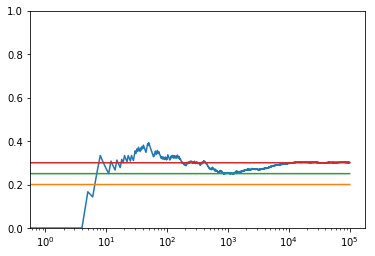

In [30]:
run_experiment(0.2, 0.25, 0.3, 100000)

In the long run, the average conversion converges to p3, which is our best bandit. 

## Confidence Internal Approximation vs Beta Posterior

In [31]:
from scipy.stats import beta, norm

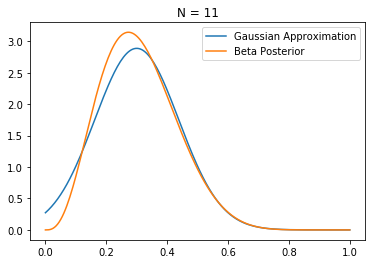

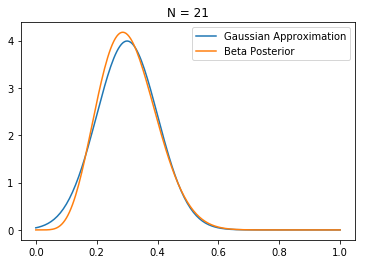

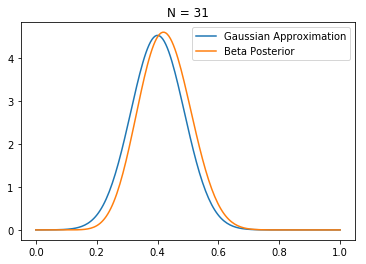

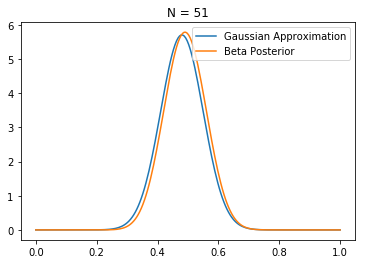

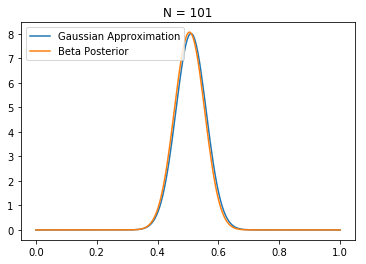

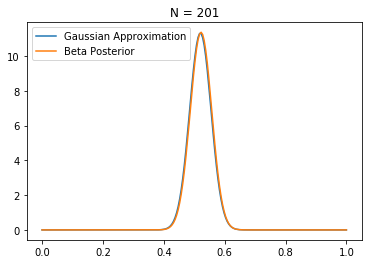

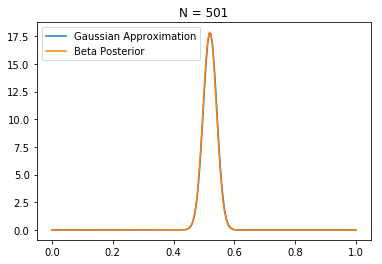

In [32]:
T = 501 #trials
true_ctr = 0.5
a, b = 1, 1 # non-informative, uniform dist priors
plot_indices = (10, 20, 30, 50, 100, 200, 500)
data = np.empty(T)

# generate some data
for i in range(T):
    x = 1 if np.random.random() < true_ctr else 0 # we get a random sample
    data[i] = x # we store the sample
    
    a += x # we update the Beta dist.
    b += 1-x
    
    if i in plot_indices:
        p = data[:i].mean()
        n = i+1
        std = np.sqrt(p*(1-p)/n)
        
        x = np.linspace(0,1,200)
        g = norm.pdf(x, loc = p, scale = std)
        plt.plot(x, g, label = "Gaussian Approximation")
        
        posterior = beta.pdf(x, a = a, b = b)
        plt.plot(x, posterior, label = "Beta Posterior")
        plt.legend()
        plt.title("N = %s" % n)
        plt.show()